## 2023 Open Science Data Challenge - Level 1
## Hyperparameter tuning for Data Gathering From Landsat
## Team: Devashish Mahajan

### Team Members:
### 1) Devashish Mahajan
### 2) Rohit Chaudhari

This notebook helps to select proper hyper parameters for collecting NDVI data from Landsat satellite. 
Surrounding box around latitude and longitude determines area of land under observtion. Larger the box size, larger the area of land under observation.
box_size_deg : It detemines surrounding box around the latitude and longitude location.

#### 1 deg = 111 Kilometer

For box_size_deg =  0.10 (0.1 deg = 11.1 Kilometer), land under observation = 123.21 sq. km.

For box_size_deg = 0.010 (0.01 deg = 1.11 Kilometer), land under observation = 1.2321 sq. km.

Larger land under observation may cause unneccessary land included while calculating NDVI, which will give wrong results.

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import pandas as pd
from tqdm import tqdm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

In [2]:
# Read crop location trainig data file
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv") 
print(crop_presence_data.info())
print(crop_presence_data['Class of Land'].value_counts())
print(crop_presence_data.head())
print(crop_presence_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Latitude and Longitude  600 non-null    object
 1   Class of Land           600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB
None
Rice        300
Non Rice    300
Name: Class of Land, dtype: int64
                     Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice
                       Latitude and Longitude Class of Land
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)    

## Hyperparameter tunning before collecting satellite data
1) box_size_deg : It detemines surrounding box around the latitude and longitude location

2) resolution : It detemines the resoltion of output image

3) time window : It detemines the time period for which data need to be fetched from satellite

# Trail 1
## box_size_deg = 0.10 (1 deg = 111 Kilometer, so 0.1 deg = 11.1 Kilometer)
## resolution = 60

In [3]:

lat_long = (10.323727047081501, 105.2516346045924)


box_size_deg = 0.10 # Surrounding box in degrees

# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

# Define the time window
time_window="2021-11-01/2022-05-30"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 60  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

This is the number of scenes that touch our region: 43


In [4]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 186, longitude: 186, time: 43)
Coordinates:
  * latitude     (latitude) float64 10.37 10.37 10.37 ... 10.27 10.27 10.27
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.3 105.3 105.3
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-11-05T03:14:47.989597 ... 2022-05...
Data variables:
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 186, 186), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 186, 186), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 186, 186), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 dask.array<chunksize=(1, 186, 186), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 dask.array<chunksize=(1, 186, 186), meta=np.ndarray>

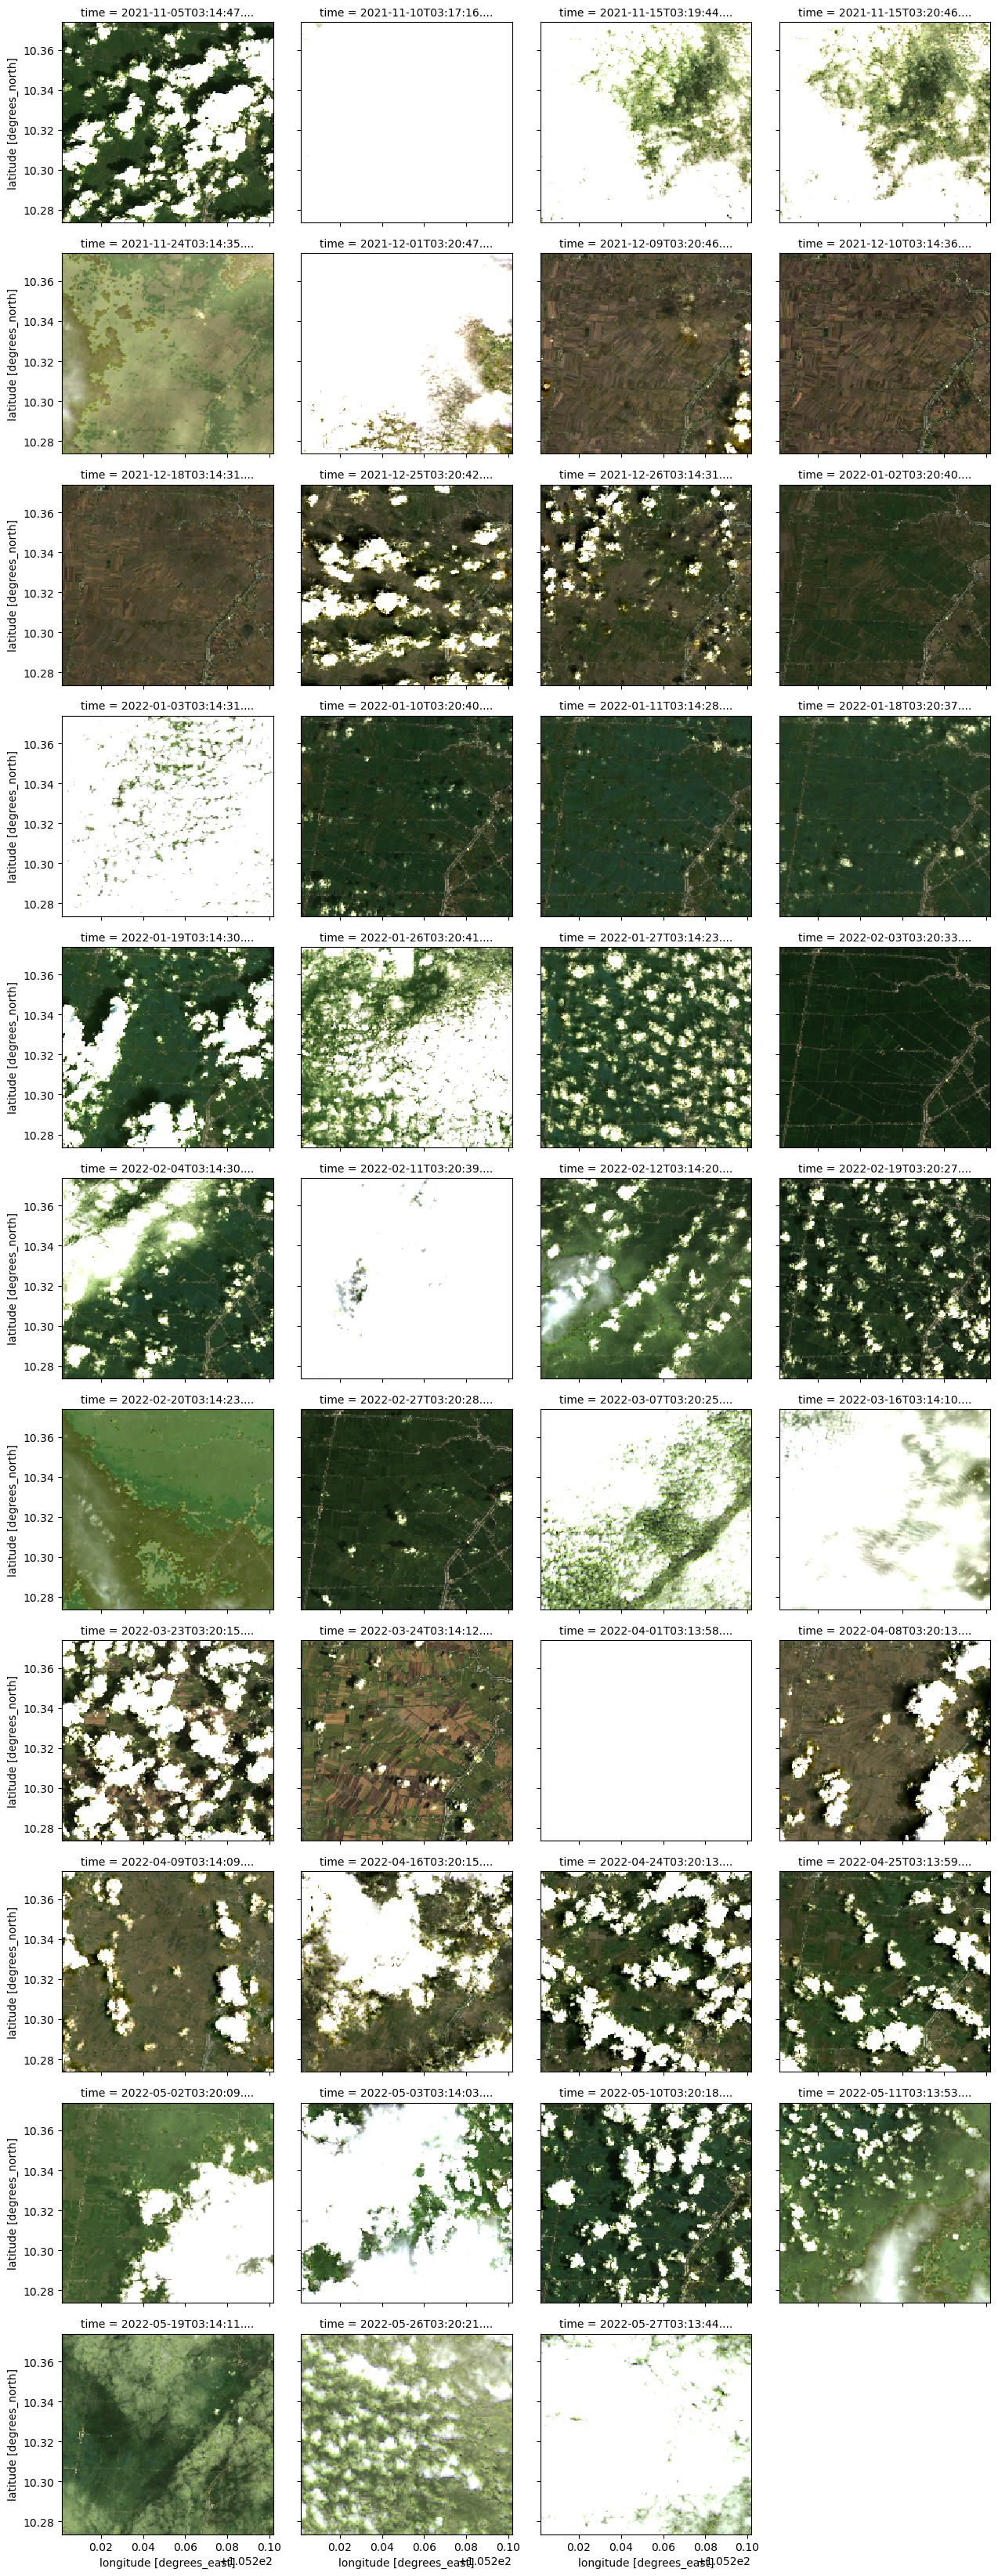

In [5]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

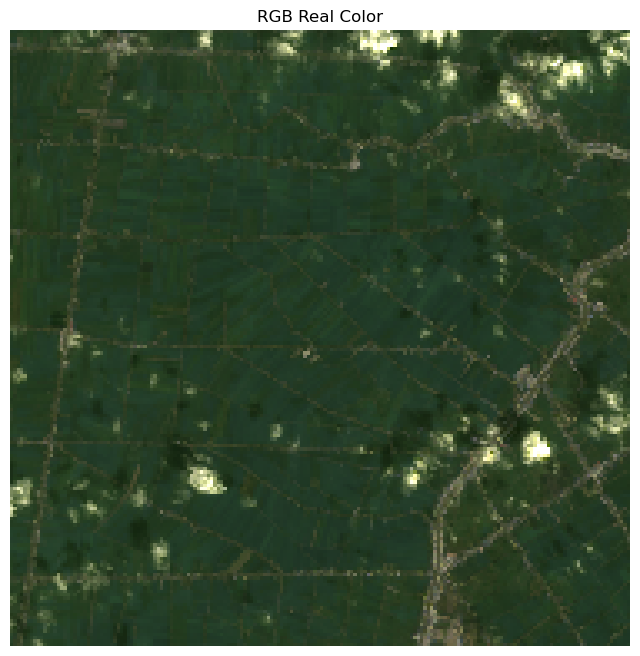

In [6]:
time_slice = 15
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

# Trail 2
## box_size_deg = 0.010 (1 deg = 111 Kilometer, so 0.01 deg = 1.11 Kilometer)
## resolution = 10

In [7]:

lat_long =  (10.323727047081501, 105.2516346045924)

box_size_deg = 0.010 # Surrounding box in degrees

# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

# Define the time window
time_window= "2021-11-01/2022-05-30"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 #111320.0 # degrees per pixel for CRS:4326 

xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

This is the number of scenes that touch our region: 43


In [8]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 112, longitude: 112, time: 43)
Coordinates:
  * latitude     (latitude) float64 10.33 10.33 10.33 ... 10.32 10.32 10.32
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.3 105.3 105.3
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-11-05T03:14:47.989597 ... 2022-05...
Data variables:
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 112, 112), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 112, 112), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 112, 112), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 dask.array<chunksize=(1, 112, 112), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 dask.array<chunksize=(1, 112, 112), meta=np.ndarray>

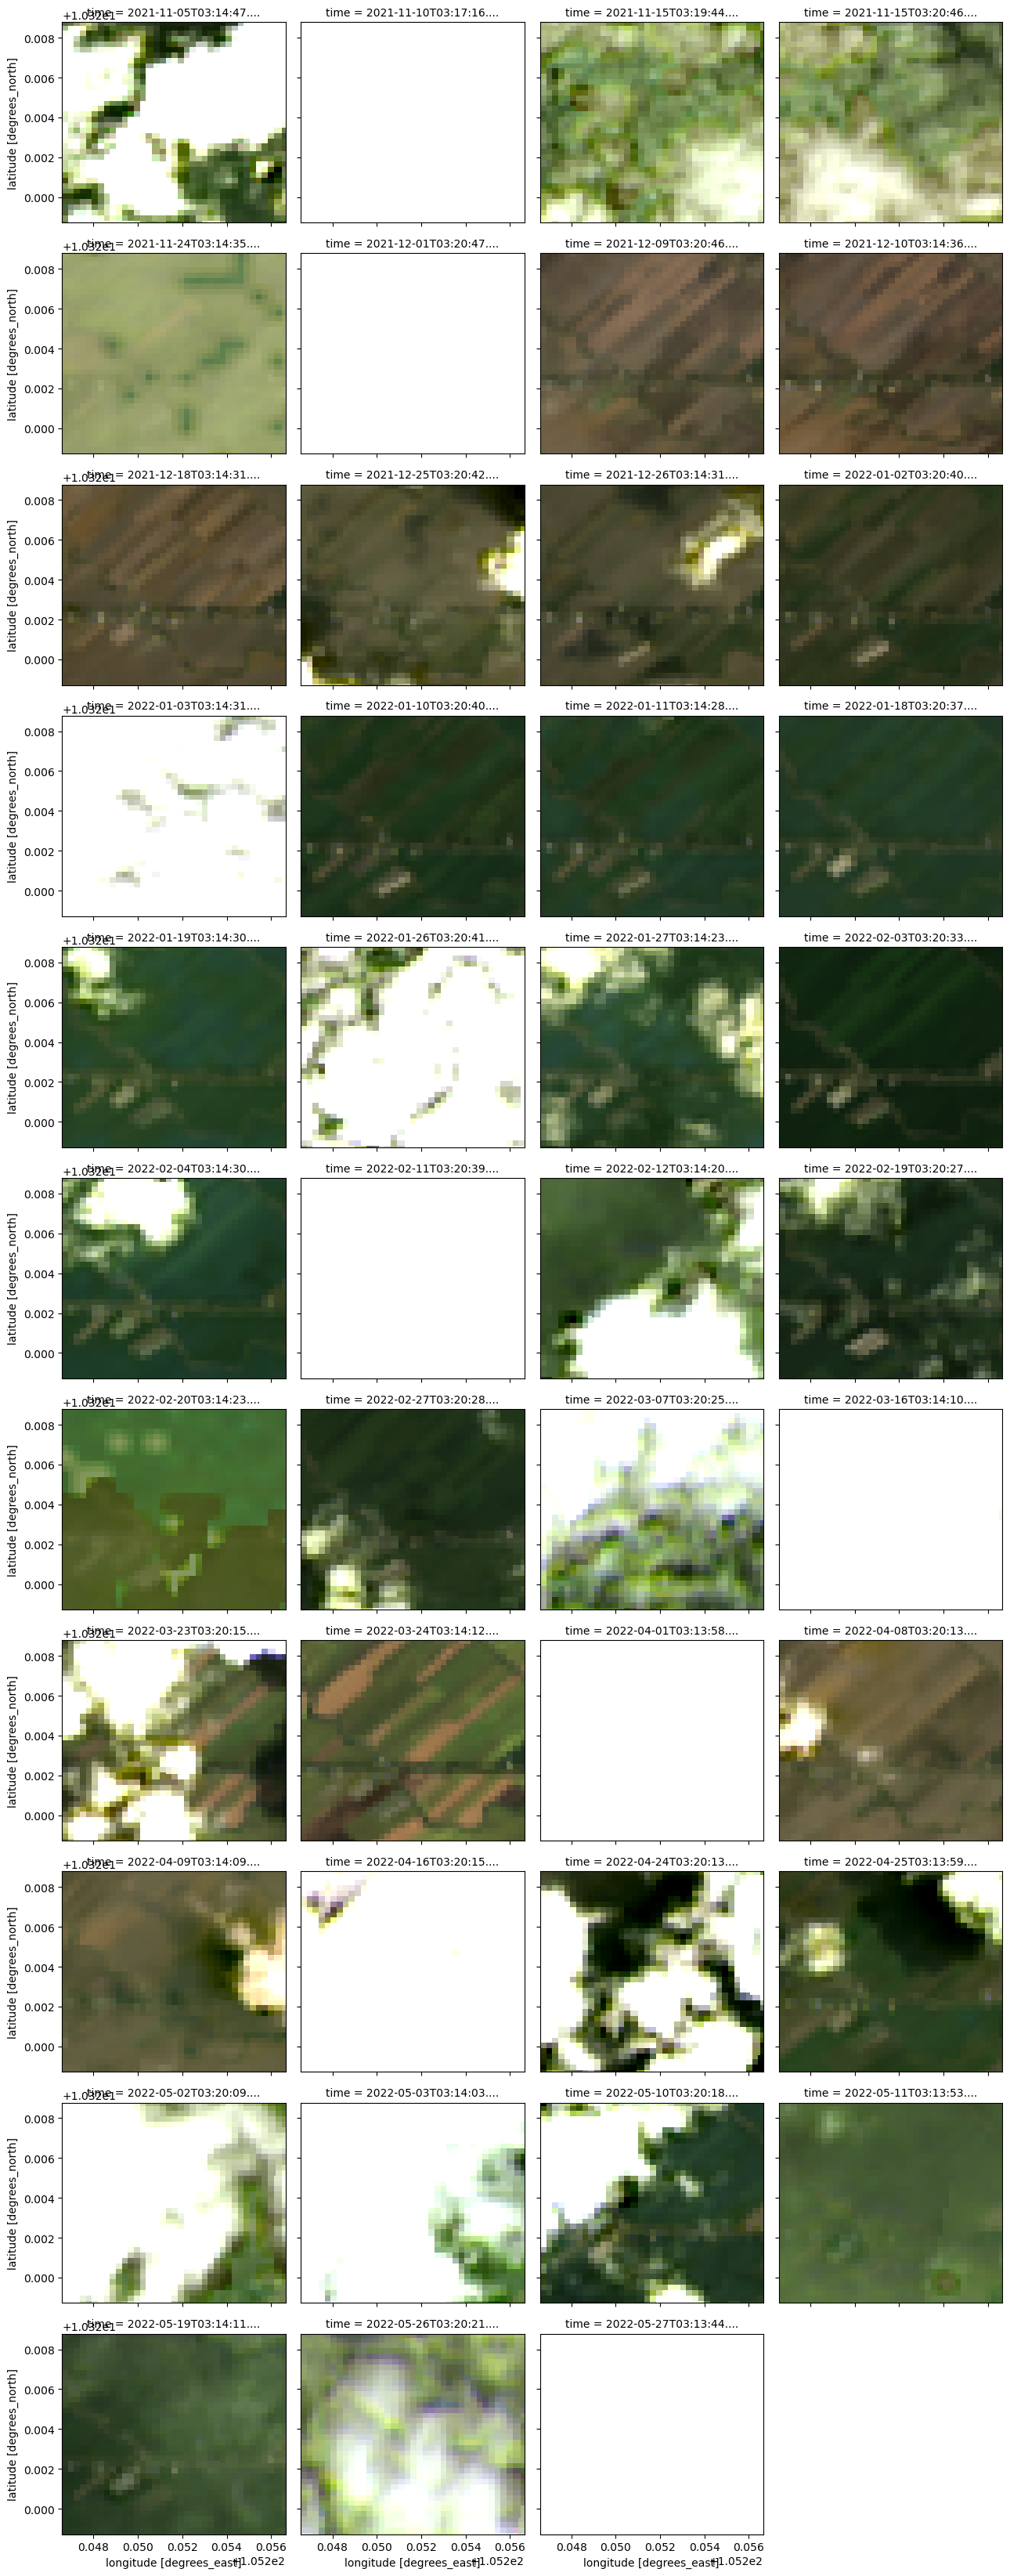

In [9]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

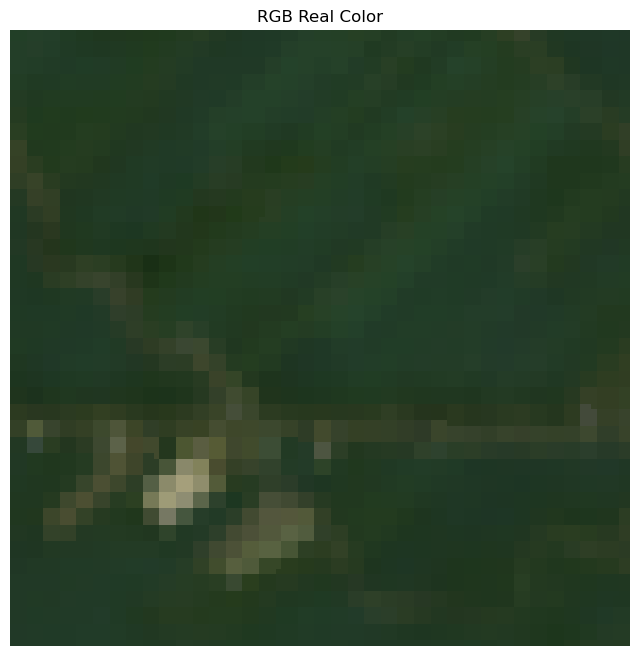

In [10]:
time_slice = 15
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

Cloud masking for Landsat Collection-2 Level-2 data can be complicated. The <b>"qa_pixel"</b> band is used to assess each pixel and determine its cloud or water classification. The code below is credited to Mauricio Cordiero. See his webpage [HERE](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for a more detailed explanation of the process. Also, you can visit the Landsat-8 Collection-2 Level-2 Product Guide [HERE](https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide) for more details about the cloud mask values. In the end, we are searching for clouds, cloud shadows, and water to create a mask for any given region. This will allow us to extract the "clear" pixels to assess the vegetation state. 

In [11]:
# To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
# See the website above for a nice explanation of the process

bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2,  #2
            'cloud': 1<<3, #3
            'shadow': 1<<4, 
            'snow': 1<<5, #5
            'clear': 1<<6,
            'water': 1<<7 #7
}

In [12]:
# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):
    
    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # Loop through the flags  
    for flag in flags_list:
        
        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [13]:
# Pick a single time slice to view a mask with clouds and water
sample_xx = xx.isel(time=time_slice)

In [14]:
# Find the pixels that are no data (fill), clouds, cloud shadows, or water
my_mask = get_mask(sample_xx['qa_pixel'],
                   ['fill', 'dilated_cloud', 'cirrus', 
                    'cloud', 'shadow', 'water'])

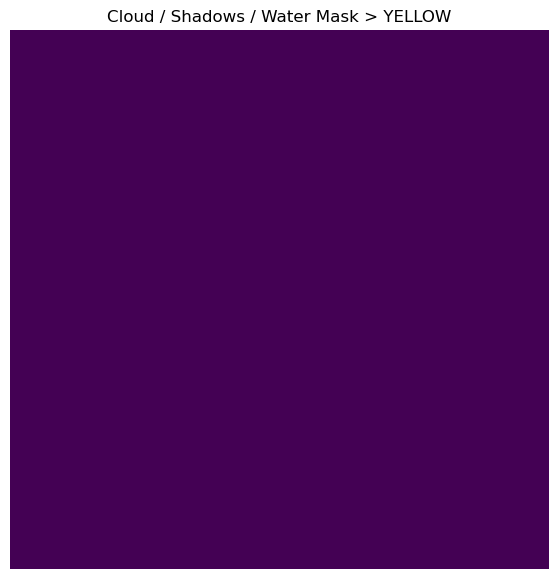

In [15]:
# Show only the mask (Yellow) with valid data in Purple
plt.figure(figsize=(7,7))
plt.imshow(my_mask)
plt.title("Cloud / Shadows / Water Mask > YELLOW")
plt.axis('off')
plt.show()

In [16]:
# Create an RGB function that will display the mask over the background RGB image

def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb

In [17]:
rgb = plot_masked_rgb(sample_xx['red'], sample_xx['green'], sample_xx['blue'], my_mask, color_mask=(1, 0, 1), transparency=0.2, brightness=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


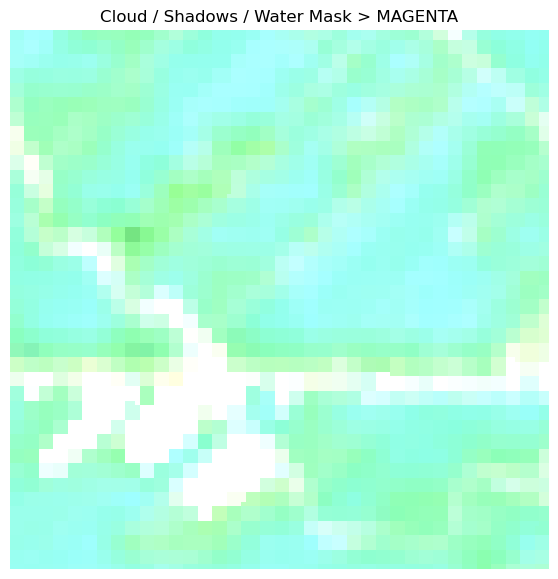

In [18]:
# This is a nice image that shows the clouds and water pixels (Purple) among clear land pixels
plt.figure(figsize=(7,7))
plt.imshow(rgb)
plt.title("Cloud / Shadows / Water Mask > MAGENTA")
plt.axis('off')
plt.show()

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water), middle values (0.25 to 0.6) reflect crops in their growing state, and high values (0.6 to 1.0) reflect crops at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).
    
The NDVI plot below shows all (unfiltered) pixels (BLUE) and filtered pixels (GREEN). In cases where the filtered data is entirely masked out, it is possible there are no available "clean" pixels to calculate NDVI. This is why there are sometimes "gaps" in the filtered dataset (GREEN) and the line has "gaps". At times when the filtered and unfiltered NDVI values are similar, this suggests low cloud volume in the sample. At times where the filtered and unfiltered NDVI values are very different, this suggests high cloud volume in the sample which tends to adversely lower NDVI. For these reasons, it is important to filter clouds out of the data before calculating NDVI for a given region coincident with an agriculture plot. This will yield the most accurate phenology results.

In [19]:
# Calculate the mask for the entire xarray (all time slices)
full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow','water'])

In [20]:
# Create a "clean" dataset with the mask applied 
cleaned_data = xx.where(~full_mask)

In [21]:
# Calculate the mean of the data across the sample region and then NDVI
# Perform this calculation for the unfiltered and cloud-filtered (clean) datasets
mean_unfiltered = xx.mean(dim=['longitude','latitude']).compute()
ndvi_mean = (mean_unfiltered.nir08-mean_unfiltered.red)/(mean_unfiltered.nir08+mean_unfiltered.red)
mean_clean = cleaned_data.mean(dim=['longitude','latitude']).compute()
ndvi_mean_clean = (mean_clean.nir08-mean_clean.red)/(mean_clean.nir08+mean_clean.red)

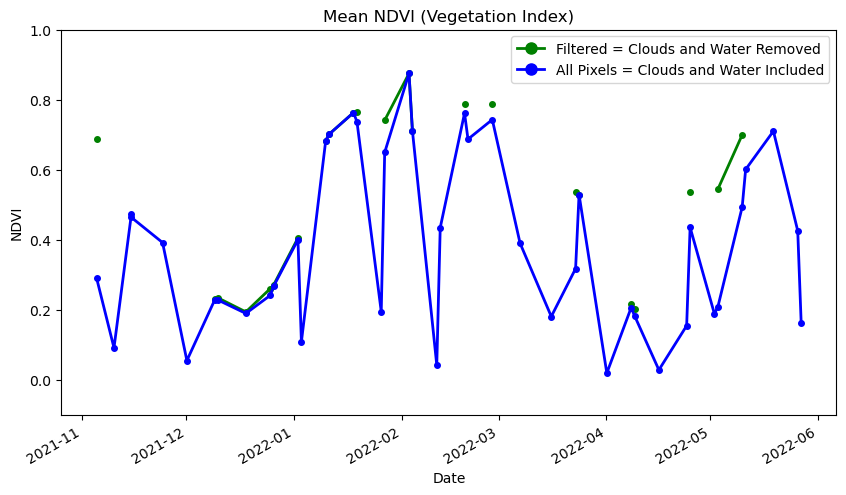

In [22]:
fig = plt.figure(figsize=(10, 5))
ndvi_mean_clean.plot(color='green',marker='o',markersize=4,linewidth=2, label="Filtered = Clouds and Water Removed")
ndvi_mean.plot(color='blue',marker='o',markersize=4,linewidth=2, label="All Pixels = Clouds and Water Included")
plt.title("Mean NDVI (Vegetation Index)")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.ylim(-0.1,1.0)
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=10)
plt.show()

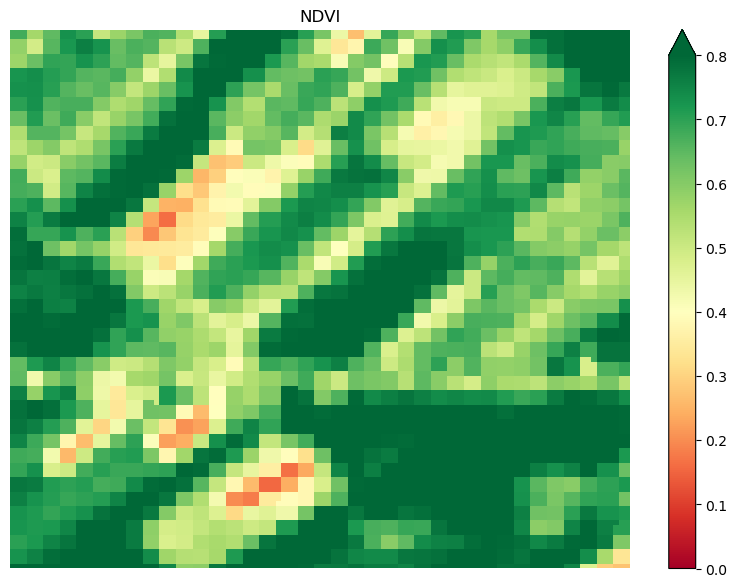

In [23]:
# Plot an NDVI image for a single date with few clouds
# We will select image (index=6) on January 2, 2022. Notice how the water is masked out.

fig = plt.figure(figsize=(10, 7))
ndvi_image = (cleaned_data.nir08-cleaned_data.red)/(cleaned_data.nir08+cleaned_data.red)
ndvi_image.isel(time=13).plot(vmin=0.0, vmax=0.8, cmap="RdYlGn")
plt.title("NDVI")
plt.axis('off')
plt.show()

### From above trails it can be concluded that parameters box_size_deg = 0.010 and resolution = 10 are best parameters to collect NDVI data